In [15]:
import librosa
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import numpy as np 
from scipy.signal import tf2zpk


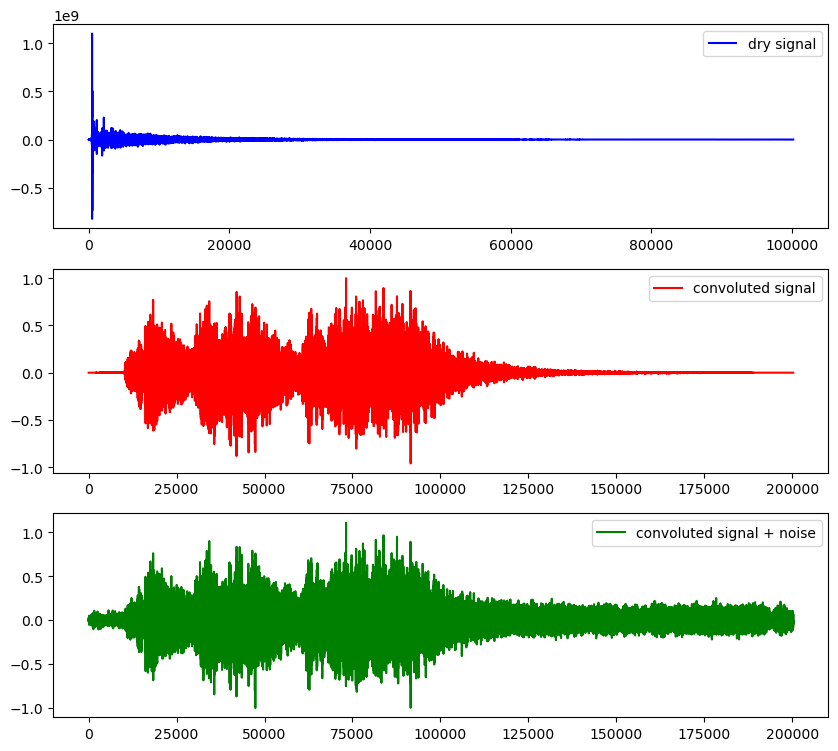

In [84]:
anechoic_audio_impulse_response_convolution_plus_noise = np.load("/workspace/unicamp/IA009/Projeto Final/data/anechoic_audio_impulse_response_convolution_plus_noise.npy")
anechoic_audio_impulse_response_convolution = np.load("/workspace/unicamp/IA009/Projeto Final/data/anechoic_audio_impulse_response_convolution.npy")
anechoic_audio_plus_noise = np.load("/workspace/unicamp/IA009/Projeto Final/data/anechoic_audio_plus_noise.npy")
anechoic_audio = np.load("/workspace/unicamp/IA009/Projeto Final/data/anechoic_audio.npy")
impulse_response = np.load("/workspace/unicamp/IA009/Projeto Final/data/impulse_response.npy")
noise = np.load("/workspace/unicamp/IA009/Projeto Final/data/noise.npy")

fig, ax = plt.subplots(3, 1, figsize=(10, 9))
ax[0].plot(impulse_response, color='blue', label='dry signal')
ax[0].legend()
ax[1].plot(anechoic_audio_impulse_response_convolution, color='red', label='convoluted signal')
ax[1].legend()
ax[2].plot(anechoic_audio_impulse_response_convolution_plus_noise, color='green', label='convoluted signal + noise')
ax[2].legend()

#### ------------------------------------ DATA PROCESSING ------------------------------------------------------

In [86]:
import numpy as np

def plot_weights_evolution(weights_evolution):
    plt.figure(figsize=(10, 6))
    for i in range(weights_evolution[0].shape[0]):  # For each weight
        plt.plot([w[i] for w in weights_evolution], label=f'Weight {i+1}')
    plt.xlabel('Iterations')
    plt.ylabel('Weight Value')
    plt.title('Evolution of Weights during LMS Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()

def normalize(signal):
    return 2 * (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) - 1

def lms(desired_signal, input_signal, step_size, filtering_order):
    # Ensure filtering_order is valid
    if filtering_order >= len(desired_signal):
        raise ValueError("Filtering order must be smaller than the length of the signals.")
    
    # Normalize input signal and desired signal
    input_signal = (input_signal - np.mean(input_signal)) / np.std(input_signal)
    desired_signal = (desired_signal - np.mean(desired_signal)) / np.std(desired_signal)
    
    weights = np.zeros(filtering_order)
    signal_length = desired_signal.shape[0]
    output_signal = np.zeros(signal_length)
    error_signal = np.zeros(signal_length)
    
    # To track weights evolution
    weights_evolution = []

    for n in range(filtering_order, signal_length):
        desired_ = desired_signal[n]
        input_ = input_signal[n-filtering_order:n]  # Extract a slice of length `filtering_order`
        output_ = np.dot(input_, weights)  # Dot product with matching shapes
        output_signal[n] = output_
        error_ = desired_ - output_
        error_signal[n] = error_
        weights += step_size * error_ * input_
        
        # Append current weights to the evolution list
        weights_evolution.append(weights.copy())

    return output_signal, weights, weights_evolution, error_signal


def find_max_step_size(input_signal, filtering_order):
    """
    Finds the maximum step size for LMS algorithm convergence.

    Parameters:
        input_signal (np.array): The input signal.
        filtering_order (int): The order of the adaptive filter.

    Returns:
        float: Maximum step size for convergence.
    """
    # Ensure input signal is normalized
    input_signal = (input_signal - np.mean(input_signal)) / np.std(input_signal)
    
    # Construct autocorrelation matrix
    signal_length = len(input_signal)
    if signal_length <= filtering_order:
        raise ValueError("Filtering order must be smaller than the length of the input signal.")

    autocorr_matrix = np.zeros((filtering_order, filtering_order))
    for i in range(filtering_order):
        for j in range(filtering_order):
            # Adjust indexing to avoid broadcasting issues
            slice_len = signal_length - max(i, j)
            autocorr_matrix[i, j] = np.mean(
                input_signal[:slice_len] * input_signal[abs(i-j):abs(i-j)+slice_len]
            )

    # Largest eigenvalue of the autocorrelation matrix
    lambda_max = np.max(np.linalg.eigvalsh(autocorr_matrix))

    # Maximum step size for convergence
    max_step_size = 2 / lambda_max
    return max_step_size

def is_minimum_phase(impulse_response, sample_rate):
    """
    Check if an impulse response is minimum phase.

    Parameters:
        impulse_response (np.array): The impulse response of the system.
        sample_rate (float): The sample rate of the system (not used for the check).

    Returns:
        bool: True if the system is minimum phase, False otherwise.
    """
    # Normalize the impulse response
    impulse_response = impulse_response / np.max(np.abs(impulse_response))

    # Get the zeros, poles, and gain of the system
    b = impulse_response  # Numerator coefficients
    a = [1]  # Denominator coefficients for FIR systems (no poles)
    zeros, poles, _ = tf2zpk(b, a)

    # Check if all zeros are inside the unit circle
    all_zeros_inside_unit_circle = np.all(np.abs(zeros) < 1)
    
    return all_zeros_inside_unit_circle

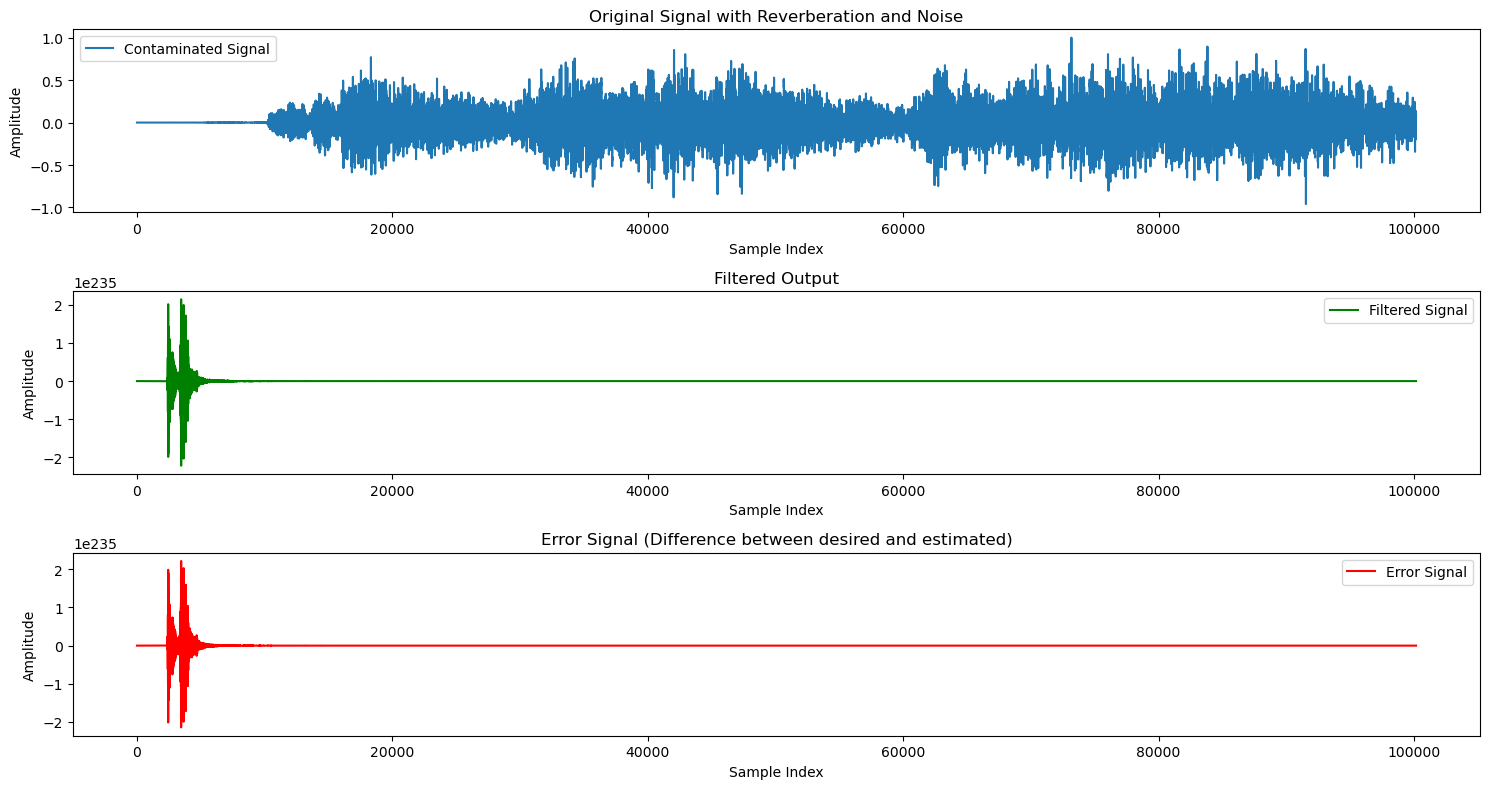

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters for LMS
step_size = 0.001  # Step size for the LMS algorithm
filtering_order = 256  # Order of the adaptive filter

# Signals
desired_signal = anechoic_audio_impulse_response_convolution[:len(impulse_response)]  # Signal to clean
input_signal = impulse_response  # Reference signal (IR)

# Apply LMS filtering
filtered_output, final_weights, weights_evolution, error_signal = lms(
    desired_signal=desired_signal,
    input_signal=input_signal,
    step_size=step_size,
    filtering_order=filtering_order
)

# Visualization
plt.figure(figsize=(15, 8))

# Original contaminated signal
plt.subplot(3, 1, 1)
plt.title("Original Signal with Reverberation and Noise")
plt.plot(desired_signal, label="Contaminated Signal")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Filtered output
plt.subplot(3, 1, 2)
plt.title("Filtered Output")
plt.plot(filtered_output, label="Filtered Signal", color="green")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Error signal
plt.subplot(3, 1, 3)
plt.title("Error Signal (Difference between desired and estimated)")
plt.plot(error_signal, label="Error Signal", color="red")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()
